# Multi-Objective Opotimization treatment of PINNs to solve the Heat Equation, which is given as 
$$
\frac{∂u(x, t)}{∂t} - κ \frac{∂^2u(x, t)}{∂x^2}=0
$$
with IC: 
$$
u(x, 0) = sin \big( π \frac{x}{(M =1)}\big), \hspace{1cm} 0 ≤ x ≤ M, 
$$
and BC:
$$
u(0, t) = u(M, t) = 0, \hspace{1cm}  t > 0
$$

The exact solution is given by  
$$
u(x, t) = sin \big( π \frac{x}{(M =1)} \big) \cdot e^{\big( \frac{-κ \pi**2}{M^2}t \big)}
$$

## TODO
* Create a random noisy data set instead of a structured noise. This is done by adding  noise (e.g., gaussian noise) to the the exact solution which we have access to from above. 
* Run the simulation for $L = αL_D + (1-α) L_P$ different $α$ and plot the following. 
    * Pareto front with the complete learning curve for each epoch. 
    * Pareto front with the final loss only ( I have done this with the data which has structured loss already)
    * Convergence (also done with the data with the structured loss already)
    * True error i.e. MSE from the exact solution. This needs to be done with the call back function. 
    * Remember to save the final trained model so that it can be later used again. 
Once we have the Pareto front, we need to comment on the convexity or non-convexity of the Pareto front. We also need to comment on the trade-off between the physics and the data loss. 
* Once we have the 
* Run the MGD algorithm for the following
$$
min \bigg[ α f_1(x),  (1-α)f_2(x) \bigg]$$
Here we need to start the training from scratch for each $α$. We want to see if using MGD, we can obtain the same Pareto front as obtained from the scalarization method. If we have the same front, then it is a good sign, otherwise we need to look into it. 
* The second thing to try out is to take the trained model from the scalarization method and use MGD to check if we can go further down in the loss. If we go further down, then it means that the fron that we have obtained using scalarization is not the true front. As mentioned, in this case, we have to use the trained model which means that we have to save the trained model. 



In [9]:
from pinntorch import *
from functools import partial

#torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [10]:
k = 1.0
M = 5.0# 0.2 # 1.0 # 5.0
T = 12.5#312.5# 0.02 # 0.5 # 12.5
X_DOMAIN = (0.0, M)
T_DOMAIN = (0.0, T)
def exact_solution(x, t):
    """returns the exact solution given the IC and the BC"""
    return torch.sin(torch.pi*x/M)*torch.exp(-k*((torch.pi**2)/(M**2))*t)

### Let us first define some book keeping plotting functions

In [11]:
def plot_data(x, t, data, grid_shape):

    """
    Takes the domain points and the result on them to plot a 3D plot.
    """

    z = data
    xt_shape = grid_shape
    color_map = cm.winter
    x = x.cpu().detach().numpy().reshape(xt_shape)
    t = t.cpu().detach().numpy().reshape(xt_shape)
    z = z.cpu().detach().numpy().reshape(xt_shape)

    # Set up plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    ax.set(xlabel='x (location)', ylabel='t (time)', zlabel='function value')

    ls = LightSource(270, 45)

    surf = ax.plot_surface(x, t, z, cmap=color_map, linewidth=0, antialiased=False, shade=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

def plot_heatmap(x, t, data, grid_shape):
    """
    Takes the domain points and the result on them to plot a heat-map.
    """
    z = data
    xt_shape = grid_shape
    color_map = plt.cm.winter
    x = x.cpu().detach().numpy().reshape(xt_shape)
    t = t.cpu().detach().numpy().reshape(xt_shape)
    z = z.cpu().detach().numpy().reshape(xt_shape)
    print(z)
    print((x.min(), x.max(), t.min(), t.max()))

    plt.imshow(z, cmap=color_map, aspect='auto', origin='upper', extent=(t.min(), t.max(), x.min(), x.max()))
    plt.colorbar(label='Function Value')
    plt.xlabel('t (time)')
    plt.ylabel('x (location)')
    plt.title('Heat Map of Function')
    plt.show()

def plot_pareto_front(L_D, L_P, data_color, cmap = 'virdis'):
    
    plt.scatter(L_D, L_P, c=data_color.detach().numpy(), cmap='viridis')  # Use 'viridis' colormap, but you can choose any other
    # Add colorbar for the z values
    cbar = plt.colorbar()
    cbar.set_label(r' $α$ Values')

    plt.xlabel(r"data loss ($L_d$)")
    plt.ylabel(r"physics loss ($L_p$)")
    #plt.yscale("log")
    #plt.xscale("log")
    plt.title("Multi-objective optimization L = $α.L_d + (1-α)L_p$")

    plt.savefig("heat_pareto_unstructured.png")
    plt.show()

def plot_training_evolutions(loss_training_evolution_data, nrows, ncols, alpha_values, figsize = (20, 20)):

    # Create a 10x5 grid of subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

    # Flatten the axes array to loop through it easily
    axes = axes.flatten()

    # Loop through each row and plot it on a separate subplot
    for i, row in enumerate(loss_training_evolution_data):
        ax = axes[i]  # Select the current subplot
        ax.plot(row)  # Plot the data
        ax.set_title(f'$α=$ {alpha_values[i]}')  # Set the title for the subplot
        ax.set_yscale("log")

    # Adjust layout to avoid overlapping titles and labels
    plt.tight_layout()

    fig.suptitle('Evolution of Training Loss for Different α Values', fontsize=16)


    plt.subplots_adjust(top=0.95)

    # Show the plot
    plt.show()

def pareto_front_evolution(L1, L2, alphas, epochs, colormap = cm.get_cmap('viridis')):

    k = 100
    # Create a scatter plot for each row, color-coded by alpha
    plt.figure(figsize=(10, 6))
    for i in range(0, len(alphas), 4):
        plt.scatter(L1[i, ::k], L2[i, ::k], c=[colormap(alphas[i])]*(epochs//k))

    # Add a colorbar to show the range of alpha
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, label=r'$\alpha$')

    plt.title("Multi-objective optimization L = $α.L_d + (1-α)L_p$")

    plt.xlabel(r"data loss ($L_d$)")
    plt.ylabel(r"physics loss ($L_p$)")
    #plt.yscale('log')
    #plt.xscale('log')
    plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_5692\2735842893.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def pareto_front_evolution(L1, L2, alphas, epochs, colormap = cm.get_cmap('viridis')):


In [12]:

def data_loss(model: nn.Module, data: torch.Tensor = None, x: torch.Tensor = None, t:torch.Tensor = None) -> torch.float:
    """"Caculates the data loss"""
    u_n = f(model, x, t) # evaluating the model
    # MSE loss 
    diff = u_n - data    # u_exact + gaussian noise 
    
    loss = diff.pow(2).mean()

    return loss

def physics_loss(
    nn_approximator: nn.Module, x: torch.Tensor = None, t: torch.Tensor = None
) -> torch.float:

    pde_loss_pre = df(nn_approximator, x, t, wrt=1, order=1) - k*df(nn_approximator, x, t, wrt=0, order=2)
    pde_loss = pde_loss_pre.pow(2).mean()
    

    t_raw = unique_excluding(t, 0.)
    x_left_boundary = fill_like(t_raw, 0.)
    x_right_boundary = fill_like(t_raw, M)
    x_raw = unique_excluding(x)
    t_zero = fill_like(x_raw, 0.)

    # dirichlet boundary conditions.  
    boundary_left = f(nn_approximator, x_left_boundary, t_raw).pow(2).mean()
    boundary_right = f(nn_approximator, x_right_boundary, t_raw).pow(2).mean()
    boundary_loss = boundary_left + boundary_right

    # initial
    initial_loss_pre = f(nn_approximator, x_raw, t_zero) - torch.sin(np.pi/M * x_raw).reshape(-1, 1)
    initial_loss = initial_loss_pre.pow(2).mean()
    
    # together
    conditional_loss = boundary_loss + initial_loss
    
    final_loss = pde_loss + conditional_loss
    return final_loss

def val_loss(
    nn_approximator: nn.Module, x: torch.Tensor, t: torch.Tensor, alpha) -> torch.float:

    pde_loss_pre = df(nn_approximator, x, t, wrt=1, order=1) - k*df(nn_approximator, x, t, wrt=0, order=2)
    pde_loss = pde_loss_pre.pow(2).mean()
    
    return (1 - alpha)*pde_loss

def total_loss(model: nn.Module, data: torch.Tensor, x_data: torch.Tensor, t_data: torch.Tensor, x_physics: torch.Tensor, t_physics: torch.Tensor, alpha: torch.float) -> torch.float:

    loss_data = data_loss(model, data, x_data, t_data)

    loss_physics = physics_loss(model, x_physics, t_physics)

    total = alpha*loss_data + (1 - alpha)* loss_physics 
    
    #print(total)
    
    return total, loss_data, loss_physics# alpha*loss_data + (1 - alpha)* loss_physics   #TODO: Get rid of the need for element wise operation.  




In [13]:
def train_model_new(
    model: nn.Module,
    loss_fn: Callable,
    loss_val_fn: Callable = None,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
    optimizer_fn = torch.optim.Adam,
    logging:bool = True,
    log_period: int = 1_000,
    epoch_callbacks : list = [],
    lr_stop_threshold = 1e-4
) -> nn.Module:
    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=1-2e-2, patience=5, threshold=1e-8, cooldown=5)
    
    for e_callback in epoch_callbacks:
        e_callback.prepare(max_epochs, model, loss_fn, optimizer_fn)
    
    Loss_p = []
    Loss_d = []
    LR = []
    L_VAL = []
    current_lr = float(optimizer.param_groups[0]["lr"])
    start_time = time.time()
    epoch = 0
    loss_physics_train = 1
    loss_physics_val = 1
    print(lr_stop_threshold)#and loss_physics_val/loss_physics_train < 1.2
    while epoch < max_epochs: #and float(optimizer.param_groups[0]["lr"]) > lr_stop_threshold:
    #for epoch in range(1, max_epochs+1):
        try:
            epoch += 1
            # calculating different losses for each epoch
            loss, loss_d, loss_p = loss_fn(model)
            loss_physics_val = 0.0
            loss_physics_val = loss_val_fn(model).detach().cpu().numpy()
            loss_physics_train = loss_p.detach().cpu().numpy()
                
            
            Loss_p.append(loss_physics_train)
            Loss_d.append(loss_d.detach().cpu().numpy())
            LR.append(float(optimizer.param_groups[0]["lr"]))
            L_VAL.append(loss_physics_val)
            
            #while len(loss.shape) > 0:
            #    loss = loss[0]
            optimizer.zero_grad()
            loss.backward(retain_graph=True) #retain_graph=True  #TODO: Need to remove the argument retain graph = True. 
            optimizer.step()
            lr_scheduler.step(loss)
            if logging:
                if epoch % log_period == 0:
                    print(f"Ep.: {epoch}\tLog10(Loss): {math.log10(float(loss)):.4f}\tLog10(Loss_p): {math.log10(float(loss_p)):.4f} \tLog10(Loss_d): {math.log10(float(loss_d)):.4f}\tExec. Time (past 1k ep.): {(time.time() - start_time):.4f}")
                    start_time = time.time()
            for e_callback in epoch_callbacks:
                e_callback.process(epoch, model, loss_fn, optimizer_fn, loss)
        except KeyboardInterrupt:
            break
    return model, Loss_p, Loss_d, LR, L_VAL

In [14]:
def create_noisy_data(mean, std_dev, exact_soln, xt_shape):

    """adds gaussian noise to the data"""

    return exact_soln + torch.randn(exact_soln.shape)*std_dev + mean 

## Let us plot the exact solution

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.57862417e-02  1.53995883e-02  1.50224054e-02 ...  1.19305543e-04
   1.16383344e-04  1.13532828e-04]
 [ 3.15685496e-02  3.07953395e-02  3.00410669e-02 ...  2.38581357e-04
   2.32737686e-04  2.27037352e-04]
 ...
 [ 3.15686762e-02  3.07954643e-02  3.00411880e-02 ...  2.38582317e-04
   2.32738617e-04  2.27038268e-04]
 [ 1.57861430e-02  1.53994923e-02  1.50223114e-02 ...  1.19304801e-04
   1.16382616e-04  1.13532114e-04]
 [-8.74227766e-08 -8.52815276e-08 -8.31927167e-08 ... -6.60703325e-10
  -6.44520437e-10 -6.28734509e-10]]
(0.0, 5.0, 0.0, 12.5)


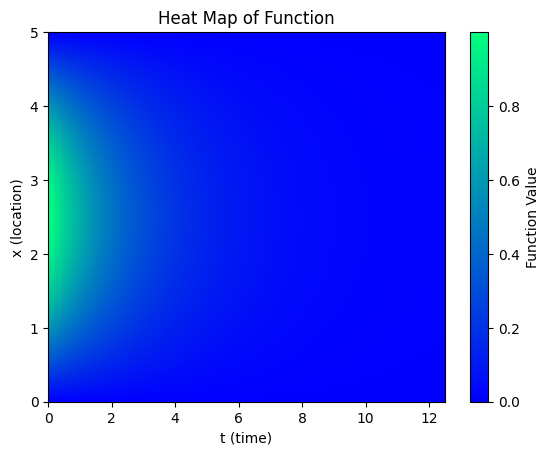

In [15]:
xt_shape = (20, 20)
x_train_d, t_train_d = generate_grid((20,20), domain=(X_DOMAIN, T_DOMAIN))
x_train_p, t_train_p = generate_grid((39,39), domain=(X_DOMAIN, T_DOMAIN))
x_val, t_val = generate_grid((77,77), domain=(X_DOMAIN, T_DOMAIN))
x_plot, t_plot = generate_grid((200,200), domain=(X_DOMAIN, T_DOMAIN))
exact_soln = exact_solution(x_train_d, t_train_d)


plot_solution = exact_solution(x_plot, t_plot)
plot_heatmap(x_plot, t_plot, plot_solution, grid_shape=(200, 200))
#plot_data(x_train_d, x_train_d, exact_soln, grid_shape=(20, 20))

### Adding noise to the data

## Training the model for a single α

tensor([0.9998, 0.9998, 0.9996, 0.9994, 0.9990, 0.9984, 0.9975, 0.9961, 0.9937,
        0.9901, 0.9843, 0.9750, 0.9604, 0.9372, 0.9004, 0.8420, 0.7494, 0.6025,
        0.3695, 0.0000])


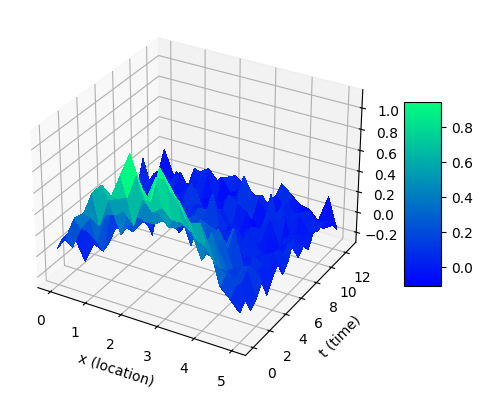

In [16]:
settings = {}
settings['seed'] = 11373
torch.manual_seed(settings['seed'])
settings['n_train_points'] = 20
settings['n_val_points'] = 80

settings['noise_level'] = 0.1
input_data = create_noisy_data(0.0, settings['noise_level'], exact_soln, xt_shape)

plot_data(x_train_d, t_train_d, input_data, (20, 20))

settings['start_learning_rate'] = 0.003
learning_rate = settings['start_learning_rate']
epochs = 50_000

def custom_color_normalize(value):
    return value**80

alphas = 1-torch.logspace(start=-2, end=0.0, steps=20, base=80)

settings['alphas'] = alphas.cpu()
print(alphas)

## Weighted sum
 Now, we train with the loss function given by $L = αL_D + (1-α) L_P$ where $α \in [0, 1]$

In [17]:
def scalar_training(alphas, input_data, x_train_d, t_train_d, x_train_p, t_train_p, x_val, t_val):
    L_p = []
    L_d = []
    L_VAL = []
    LR = []
    
    models_trained = []
    for i, alpha in enumerate(alphas):
        print("i:", i, "alpha:", alpha)
        
        loss_fn = partial(total_loss,data = input_data, x_data=x_train_d, t_data=t_train_d, x_physics=x_train_p, t_physics=t_train_p, alpha = alpha)
        loss_fn_val = partial(val_loss, x=x_val, t=t_val, alpha=alpha) # physics loss over trainig points
        
        torch.manual_seed(7245)
        model = PINN(2, 4, 50, 1, activation="fourier")
        
        trained_model, l_p, l_d, lr, l_val = train_model_new(
        model = model, 
        loss_fn=loss_fn, 
        loss_val_fn=loss_fn_val,
        learning_rate = learning_rate, 
        max_epochs = epochs, 
        optimizer_fn = torch.optim.Adam)


        L_p.append(np.array(l_p))
        L_d.append(np.array(l_d))
        LR.append(np.array(lr))
        L_VAL.append(np.array(l_val))
        models_trained.append(trained_model)

    return L_p, L_d, LR, L_VAL, models_trained

### Training with exact solution

In [18]:
Loss_p, Loss_d, LR, Loss_VAL, models_trained = scalar_training(alphas, input_data, x_train_d, t_train_d, x_train_p, t_train_p, x_val, t_val)

i: 0 alpha: tensor(0.9998)
0.0001
Ep.: 1000	Log10(Loss): -2.0916	Log10(Loss_p): -0.9157 	Log10(Loss_d): -2.0926	Exec. Time (past 1k ep.): 71.8676
Ep.: 2000	Log10(Loss): -2.2814	Log10(Loss_p): 0.4830 	Log10(Loss_d): -2.3227	Exec. Time (past 1k ep.): 63.8931
Ep.: 3000	Log10(Loss): -2.4520	Log10(Loss_p): 0.7691 	Log10(Loss_d): -2.5827	Exec. Time (past 1k ep.): 65.0532
Ep.: 4000	Log10(Loss): -2.5280	Log10(Loss_p): 0.8500 	Log10(Loss_d): -2.7307	Exec. Time (past 1k ep.): 62.6191
Ep.: 5000	Log10(Loss): -2.5649	Log10(Loss_p): 0.8719 	Log10(Loss_d): -2.8067	Exec. Time (past 1k ep.): 63.6580
Ep.: 6000	Log10(Loss): -2.5944	Log10(Loss_p): 0.8937 	Log10(Loss_d): -2.8788	Exec. Time (past 1k ep.): 61.0681
Ep.: 7000	Log10(Loss): -2.6154	Log10(Loss_p): 0.9027 	Log10(Loss_d): -2.9296	Exec. Time (past 1k ep.): 61.2201
Ep.: 8000	Log10(Loss): -2.6353	Log10(Loss_p): 0.9011 	Log10(Loss_d): -2.9698	Exec. Time (past 1k ep.): 60.7930
Ep.: 9000	Log10(Loss): -2.6519	Log10(Loss_p): 0.8979 	Log10(Loss_d): -3.0027	

In [16]:
run_name = 'heat_L1_k25_fourier'

result_dict = {
    "settings" : settings,
    "input_data": input_data.detach().cpu().numpy(),
    "loss_data": Loss_d,
    "loss_physics": Loss_p,
    "LR": LR,
    "loss_val": Loss_VAL
}

path = create_run_folder(run_name)
save_dictionary(path, run_name, result_dict)
save_models(path, models_trained)

settings
input_data
loss_data
loss_physics
LR
loss_val


tensor([[ 1.0939e-02],
        [ 3.2988e-02],
        [-3.1814e-02],
        [ 1.1592e-01],
        [-1.0097e-01],
        [ 6.3941e-02],
        [ 7.1757e-02],
        [ 7.2733e-02],
        [-6.6730e-02],
        [-1.1751e-01],
        [-4.7789e-03],
        [ 2.2679e-02],
        [ 1.1776e-01],
        [ 6.0850e-02],
        [ 1.2139e-01],
        [ 5.9138e-02],
        [ 1.6905e-01],
        [ 5.8791e-02],
        [ 1.5398e-01],
        [-6.5615e-02],
        [ 1.1471e-01],
        [-8.6855e-02],
        [-1.1165e-01],
        [ 1.7832e-01],
        [ 1.0390e-01],
        [-6.3576e-02],
        [-4.7547e-02],
        [-1.8350e-02],
        [ 2.4053e-02],
        [ 1.1514e-01],
        [ 1.4773e-01],
        [ 3.5217e-02],
        [ 4.5296e-02],
        [ 1.6216e-02],
        [-2.6181e-02],
        [ 6.6210e-03],
        [ 5.7096e-02],
        [ 1.2108e-01],
        [ 8.5863e-02],
        [-5.5703e-02],
        [ 4.6415e-01],
        [ 3.0289e-01],
        [ 2.8883e-01],
        [ 2

In [37]:
save_dir = "heat_equation/trained_models"  
os.makedirs(save_dir, exist_ok=True) # TODO: Add a conditional statement to make sure that we are not overwriting the directory. 
def save_model(model, filename):
    filepath = os.path.join(save_dir, filename)
    torch.save(model, filepath)


In [45]:
#callbacks = [TrainLossMonitor(), TrueErrorMonitor(test_points, logistic_fn), SolutionMonitor(plot_points, training_points, store_every=20)]
def weighted_training(alphas, input_data):

    #TODO: output error_true_evolution 
    #TODO: 

    L_p = torch.zeros_like(alphas) #tensor to save physics loss for each \alpha 
    L_d = torch.zeros_like(alphas) #tensor to save data loss for each \alpha
    
    loss_train_evolution = np.zeros((len(alphas), epochs))  #tensor to save training evolution for each \alpha 
    #error_true_evolution = np.zeros((len(alphas), epochs))  #tensor to save error evolution for each \alpha

    for i, alpha in enumerate(alphas):
        
        loss_fn = partial(total_loss, data = input_data, x=x_train, t = t_train,  alpha = alpha)  # For each alpha we need a loss function with different alpha. 
        callbacks = [TrainLossMonitor()]  # TODO: Include True Error Monitor here (for now it is only written for one dimension but here we have two dimensions)
        model = PINN(2, 4, 6, 1)
        trained_model = train_model(
        model = model, 
        loss_fn = loss_fn, 
        learning_rate = learning_rate, 
        max_epochs = epochs, 
        optimizer_fn = torch.optim.Adam,
        epoch_callbacks = callbacks)

        train_loss_evolution = callbacks[0].train_loss_history
        #true_error_evolution = callbacks[1].mae_history

        loss_train_evolution[i, :] = train_loss_evolution
        #error_true_evolution[i, :] = true_error_evolution

        #calculating the physics losses and data losses from trained model with a loss function dependent on α
        l_p = physics_loss(trained_model, x_train, t_train)
        l_d = data_loss(trained_model, input_data, x_train, t_train)


        L_p[i] = l_p
        L_d[i] = l_d

        model_filename = f"model_heat{i}.pth"  #TODO: Saving the ith model does not give info about α. We need to save by α. So far, it is causing trouble.
        save_model(trained_model.state_dict(), model_filename)

    return L_p, L_d, loss_train_evolution


In [19]:
alphas1, alphas2 = torch.linspace(0, 0.95, 20), torch.linspace(0.95, 1, 50)
alphas_cat3 = torch.cat((alphas1, alphas2))

In [46]:
loss_physics_cat4, loss_data_cat4, loss_training_evolution_cat4 = weighted_training(alphas_cat3, data.reshape(-1, 1))

Epoch: 1000	Log10(Loss): -3.0654	Execution Time (past 1k epochs): 3.4864
Epoch: 2000	Log10(Loss): -3.4737	Execution Time (past 1k epochs): 5.6751
Epoch: 3000	Log10(Loss): -3.7305	Execution Time (past 1k epochs): 8.1395
Epoch: 1000	Log10(Loss): -2.3581	Execution Time (past 1k epochs): 7.3122
Epoch: 2000	Log10(Loss): -2.3693	Execution Time (past 1k epochs): 9.1436
Epoch: 3000	Log10(Loss): -2.3719	Execution Time (past 1k epochs): 5.3085
Epoch: 1000	Log10(Loss): -2.0004	Execution Time (past 1k epochs): 4.7218
Epoch: 2000	Log10(Loss): -2.0551	Execution Time (past 1k epochs): 4.4471
Epoch: 3000	Log10(Loss): -2.0656	Execution Time (past 1k epochs): 4.4387
Epoch: 1000	Log10(Loss): -1.7483	Execution Time (past 1k epochs): 4.3686
Epoch: 2000	Log10(Loss): -1.8705	Execution Time (past 1k epochs): 4.4463
Epoch: 3000	Log10(Loss): -1.8859	Execution Time (past 1k epochs): 4.4186
Epoch: 1000	Log10(Loss): -1.7728	Execution Time (past 1k epochs): 4.3764
Epoch: 2000	Log10(Loss): -1.7748	Execution Time (pa

## Loading the saved models. 
By now, we have saved the models. Now is the time to load them again. First we need to initialize the model and then we can load the models that we  have saved. After loading, we want to try the following. 
* Plot the Eucledian norms of the models correcponding to each α. 
* Maybe we can do BGD starting from a particular α and see if we can minimize the loss further. 

In [60]:
#current_dir = os.getcwd()
#print(current_dir+"/heat_equation/trained_models")

/home/junaid/sciebo - Akhter, Junaid (jakhter@uni-paderborn.de)@uni-paderborn.sciebo.de/Paderborn/PhD/Research_directions/MultiCriteria/phd_code/pinn-torch-main/examples/Junaid/mopinns/working_examples/heat_equation/trained_models


In [14]:
def euclidean_norm(parameters1, parameters2):
    squared_diff_sum = 0.0
    for name in parameters1:
        diff = parameters1[name] - parameters2[name]
        squared_diff_sum += torch.sum(diff ** 2)
    return torch.sqrt(squared_diff_sum)

In [26]:
save_dir = "heat_equation/trained_models"  # directory containing trained models  

norm_list = []
for i in range(len(alphas_cat3)-1):
    model = PINN(2, 4, 6, 1)
    model_next = PINN(2, 4, 6, 1)
    
    model.load_state_dict(torch.load(os.getcwd()+"/"+save_dir+f"/model_heat{i}.pth"))
    model_next.load_state_dict(torch.load(os.getcwd()+"/"+save_dir+f"/model_heat{i+1}.pth"))

    w = model.state_dict()
    w_next = model_next.state_dict()

    norm_list.append(euclidean_norm(w, w_next))
    

In [27]:
len(norm_list)

69

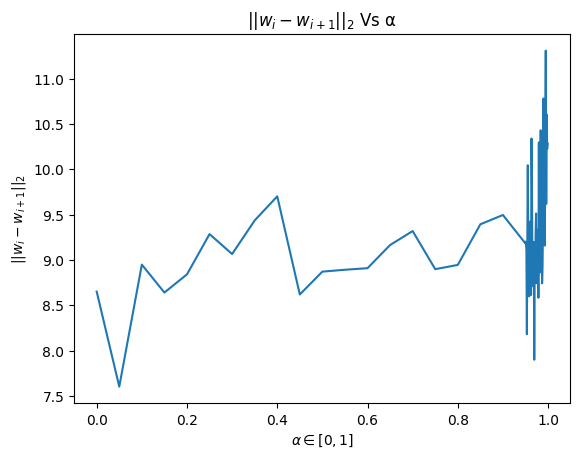

In [42]:
plt.plot(alphas_cat3[:-1], norm_list)
plt.xlabel(r"$\alpha \in [0, 1]$")
plt.ylabel(r"$||w_i - w_{i+1}||_2$")
plt.title(r"$||w_i - w_{i+1}||_2$ Vs α")
plt.savefig("heat_norms.png")

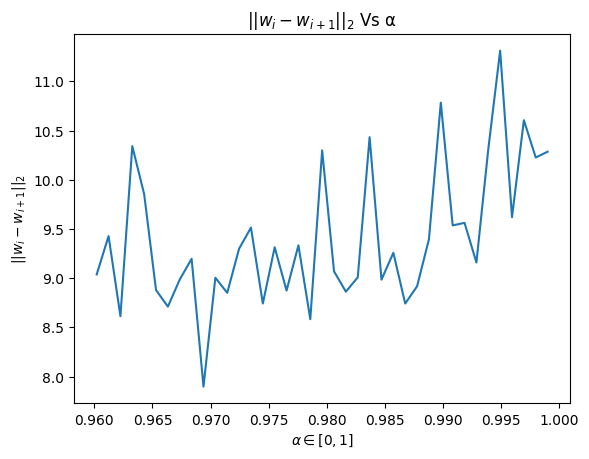

In [41]:
plt.plot(alphas_cat3[30:-1], norm_list[30:])
plt.xlabel(r"$\alpha \in [0, 1]$")
plt.ylabel(r"$||w_i - w_{i+1}||_2$")
plt.title(r"$||w_i - w_{i+1}||_2$ Vs α")
plt.savefig("heat_norms1.png")